In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter

from itertools import combinations
from datetime import datetime



import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error



import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.grid"] = 0



#  Forecasting with Prophet

In [2]:
df = pd.read_csv("online_retail_final.csv")
display(df.head())

print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


(392735, 9)




# 1) Data Preparation for Time Series

We will use only UK sales for this analysis.

In [3]:
df.Country.value_counts()

Country
United Kingdom          351196
Germany                   8624
France                    8005
EIRE                      6997
Spain                     2406
Netherlands               2025
Belgium                   1929
Switzerland               1808
Portugal                  1422
Australia                 1041
Norway                    1037
Italy                      739
Channel Islands            738
Finland                    646
Cyprus                     600
Austria                    382
Denmark                    364
Sweden                     354
Poland                     322
Japan                      300
Israel                     244
Unspecified                244
Singapore                  212
Iceland                    181
USA                        179
Canada                     147
Greece                     141
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45


In [4]:
df = df[df.Country == "United Kingdom"]

In [5]:
df.loc[:, "InvoiceDate"] = pd.to_datetime(df.loc[:, "InvoiceDate"])

print(f"First observation on data is {df.InvoiceDate.min()}")
print(f"Last observation on data is {df.InvoiceDate.max()}")

print(f"We have {(df.InvoiceDate.max() - df.InvoiceDate.min()).days} days.")

First observation on data is 2010-12-01 08:26:00
Last observation on data is 2011-12-09 12:49:00
We have 373 days.


We have 373 days sales record. Daily data can be more suitable.

In [7]:
df.set_index("InvoiceDate", inplace = True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,white metal lantern,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,United Kingdom,20.34




# 1.1) Weekly

In [8]:
prices_df = pd.DataFrame(df.groupby("InvoiceDate").TotalPrice.sum())
prices_df = prices_df.iloc[:-1]
prices_df

,TotalPrice
InvoiceDate,
2010-12-01 08:26:00,139.12
2010-12-01 08:28:00,22.20
2010-12-01 08:34:00,348.78
2010-12-01 08:35:00,17.85
2010-12-01 09:00:00,204.00
...,...
2011-12-09 12:20:00,145.29
2011-12-09 12:21:00,29.88
2011-12-09 12:23:00,124.60


In [9]:
weekly_prices = prices_df.resample("W").sum()
weekly_prices.head()

,TotalPrice
InvoiceDate,
2010-12-05,118082.07
2010-12-12,145153.96
2010-12-19,127871.19
2010-12-26,27718.88
2011-01-02,0.00


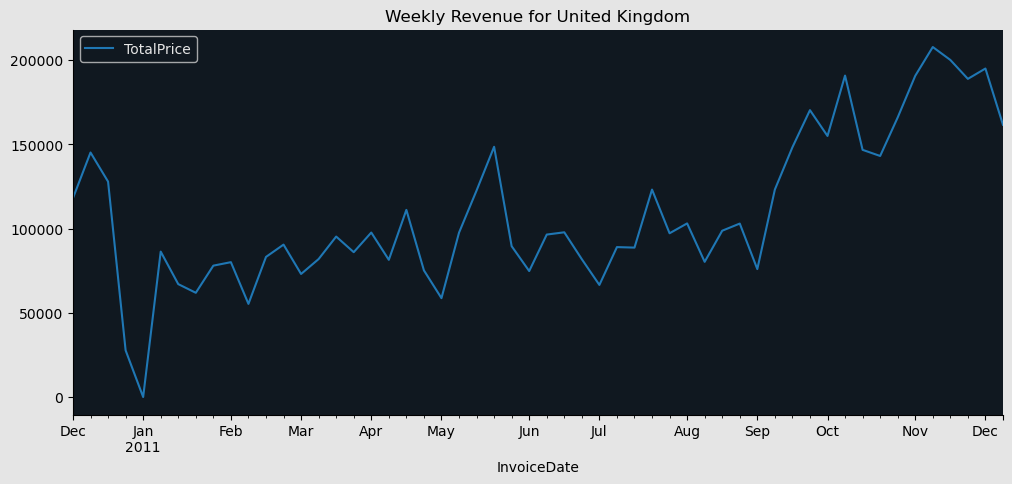

In [10]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

weekly_prices.plot(ax = ax).set_title("Weekly Revenue for United Kingdom")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.show()

Here, we have revenue per week graph. Let's interpret it.

Earlier January, this retailer was closed. Revenue is 0.

We see first peak in the middle of May.

Second peak is in the beginning of October.

Then the revenue top out in the middle of November.
At last Sales remain higher for the remainder of the end of the year with highest at mid november compared to throughout the year



# 1.2) Daily Data

 convert data to daily form with using resample method.

In [11]:
daily_sales = pd.DataFrame(df.groupby("InvoiceDate").sum().resample("D").sum()["TotalPrice"])
daily_sales

,TotalPrice
InvoiceDate,
2010-12-01,34662.95
2010-12-02,40698.98
2010-12-03,17916.64
2010-12-04,0.00
2010-12-05,24803.50
...,...
2011-12-05,45548.33
2011-12-06,38424.19
2011-12-07,31102.15


We saw that there is a zero revenue week in earlier January.

In [12]:
daily_sales.loc["2010-12-23" : "2011-1-4"]

,TotalPrice
InvoiceDate,
2010-12-23,3963.97
2010-12-24,0.00
2010-12-25,0.00
2010-12-26,0.00
2010-12-27,0.00
2010-12-28,0.00
2010-12-29,0.00
2010-12-30,0.00
2010-12-31,0.00


In [13]:
daily_sales.reset_index(inplace = True)
daily_sales["Closed"] = np.where((daily_sales.TotalPrice == 0), 1, 0)
daily_sales.set_index("InvoiceDate", inplace = True)

In [14]:
daily_sales["weekday"] = daily_sales.index.day_name()
daily_sales

,TotalPrice,Closed,weekday
InvoiceDate,,,
2010-12-01,34662.95,0,Wednesday
2010-12-02,40698.98,0,Thursday
2010-12-03,17916.64,0,Friday
2010-12-04,0.00,1,Saturday
2010-12-05,24803.50,0,Sunday
...,...,...,...
2011-12-05,45548.33,0,Monday
2011-12-06,38424.19,0,Tuesday
2011-12-07,31102.15,0,Wednesday


In [15]:
daily_sales[daily_sales.TotalPrice == 0].weekday.value_counts()

weekday
Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: count, dtype: int64

Okey, we don't have any record at 69 days. 53 of 69 is saturday. This retailer could be closed on saturdays. Let's look at total revenues per weekday.

In [16]:
daily_sales.groupby("weekday").TotalPrice.sum()

weekday
Friday        863095.82
Monday        951880.49
Saturday           0.00
Sunday        670059.45
Thursday     1267947.65
Tuesday      1049568.92
Wednesday    1100971.37
Name: TotalPrice, dtype: float64

Yeap, this retailer closed on saturdays.

In [17]:
daily_sales_workdays = daily_sales[daily_sales.TotalPrice > 0].copy()
daily_sales.drop("weekday", axis = 1, inplace = True)
daily_sales_workdays.drop("weekday", axis = 1, inplace = True)

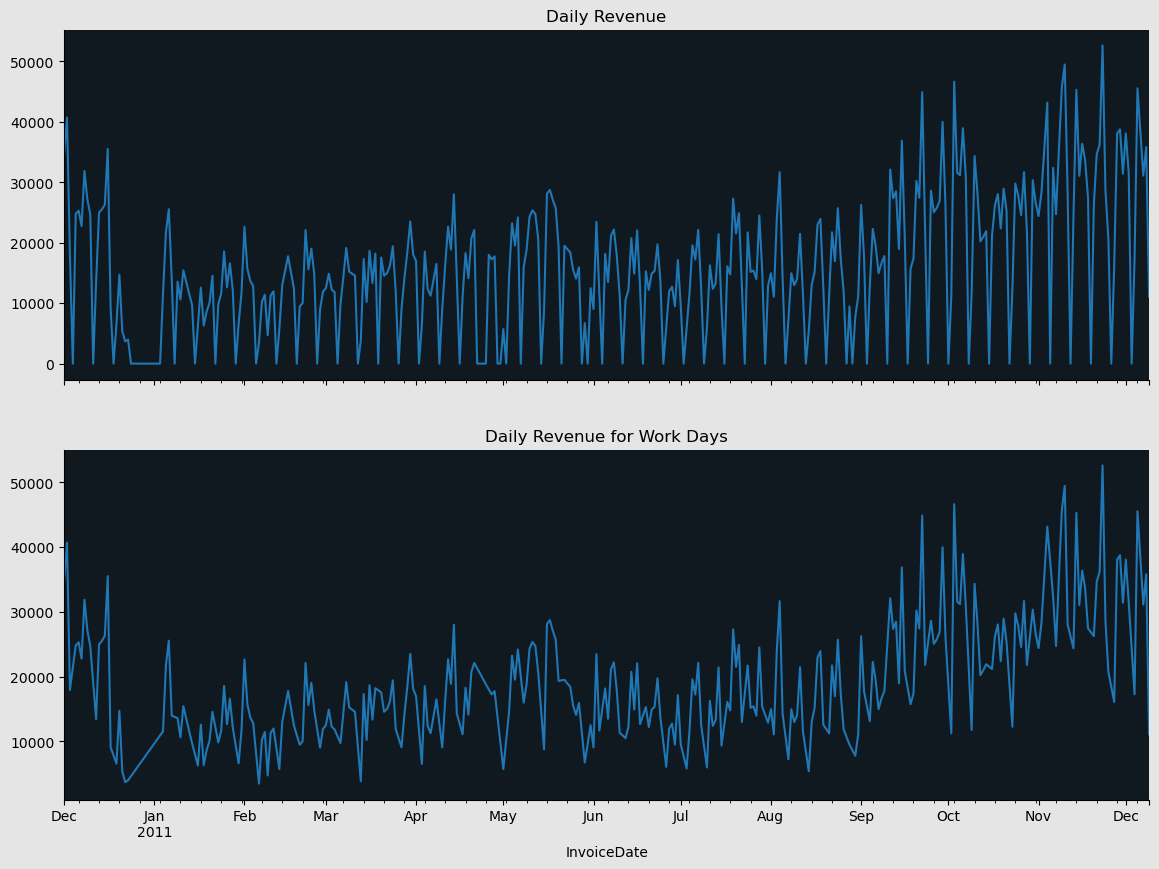

In [18]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

daily_sales.TotalPrice.plot(ax = axes[0]).set_title("Daily Revenue")
daily_sales_workdays.TotalPrice.plot(ax = axes[1]).set_title("Daily Revenue for Work Days")

sns.despine()
plt.show()



# 2) Stationarity

As we can see above daily revenue graphs, we have an increasing trend for end of the year.

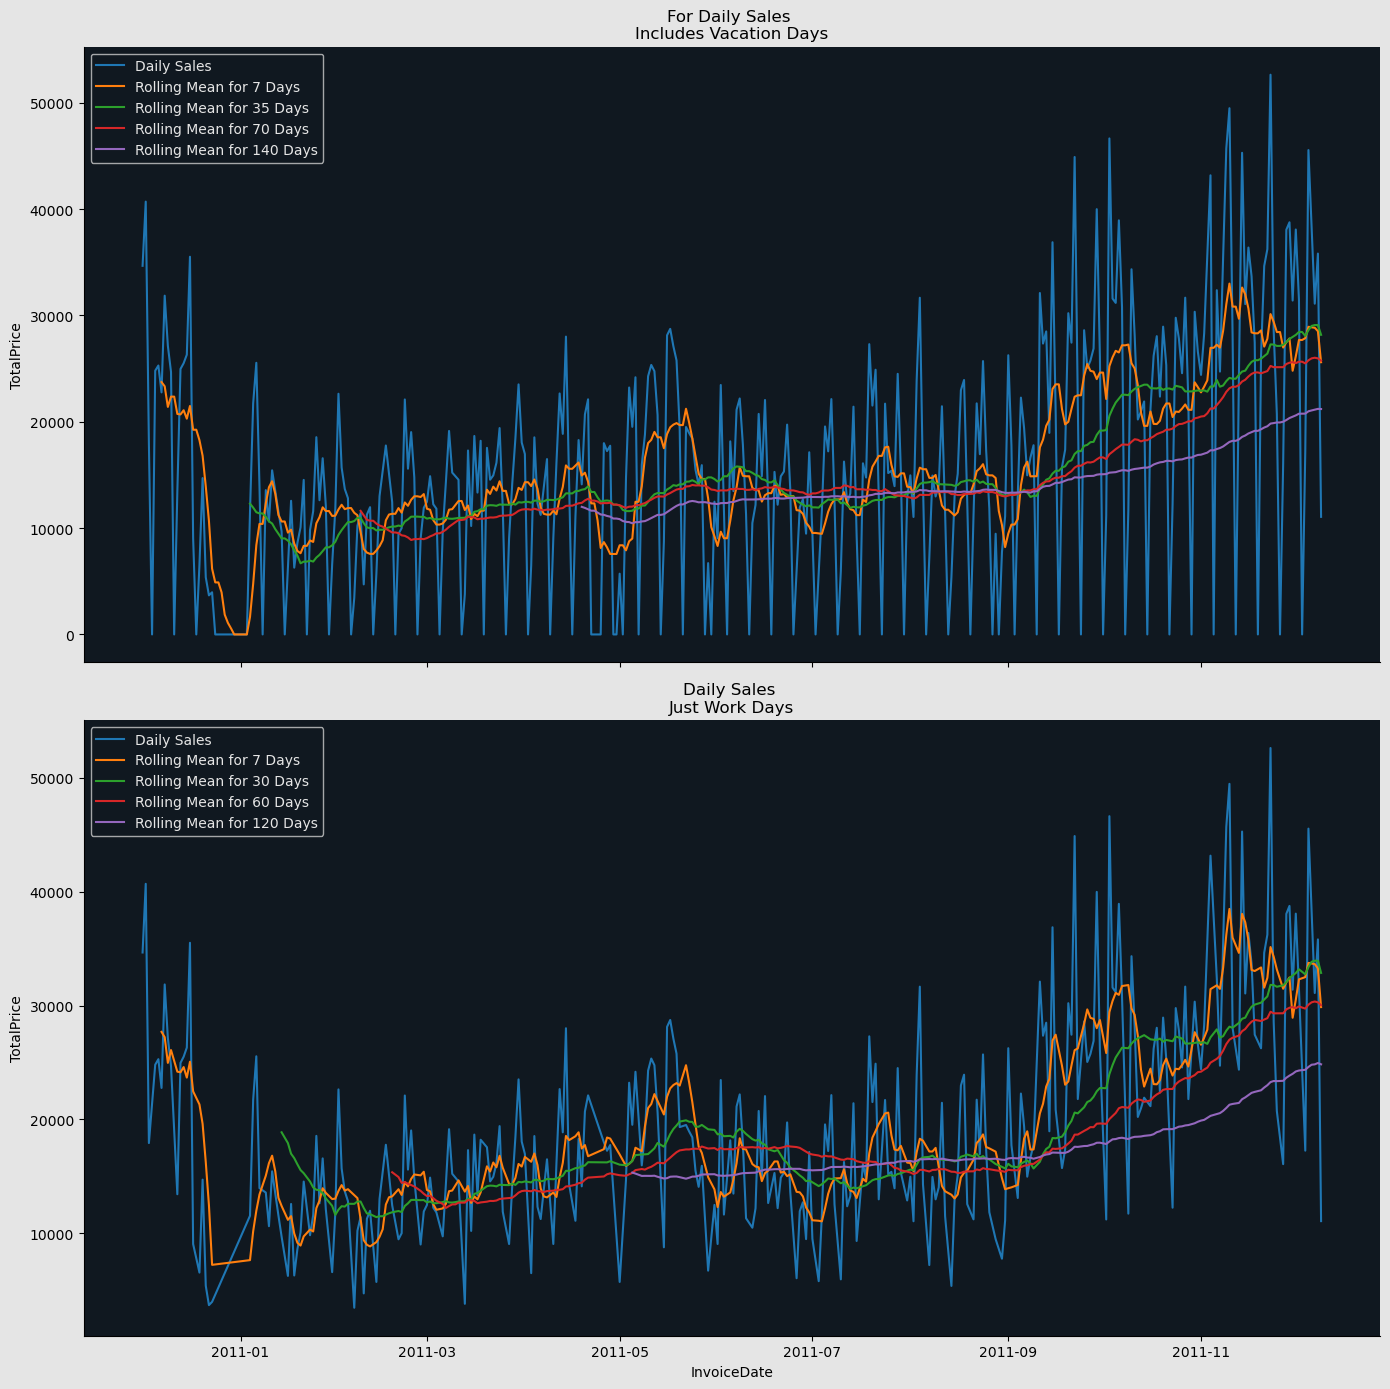

In [21]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 14), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice,
             ax = axes[0], label = "Daily Sales").set_title("For Daily Sales \nIncludes Vacation Days")

sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(7).mean(),
             ax = axes[0], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(35).mean(),
             ax = axes[0], label = "Rolling Mean for 35 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(70).mean(),
             ax = axes[0], label = "Rolling Mean for 70 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(140).mean(),
             ax = axes[0], label = "Rolling Mean for 140 Days")


sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice,
             ax = axes[1], label = "Daily Sales").set_title("Daily Sales \nJust Work Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(6).mean(),
             ax = axes[1], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(30).mean(),
             ax = axes[1], label = "Rolling Mean for 30 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(),
             ax = axes[1], label = "Rolling Mean for 60 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(120).mean(),
             ax = axes[1], label = "Rolling Mean for 120 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.tight_layout()
plt.show()

Let's check stationarity. Stationarity simply means that, our series has constant mean, variance on different times.

In above rolling mean plots, we saw that our mean values increase over time.

But, let's check it with Augmented Dickey Fuller test.



# 2.1) Augmented Dickey-Fuller Test

In [22]:
def check_adf(series, check = 0.05):

    adf = adfuller(series, autolag = "AIC")

    print(f"H0: {series.name} is non-stationary.")
    print(f"H1: {series.name} is stationary.\n")

    test_stat = adf[0]; 
    print(f"ADF test statistic: {adf[0]}")
    
    pvalue = adf[1];
    print(f"p-value: {adf[1]}")
    
    print(f"Number of lags: {adf[2]}")
    print("\nCritical Values : \n")
    
    for key, item in adf[4].items(): 
        print("\t", key, "\t", item)

    print(f"\nFor {check} significance level: \n")
    if pvalue < check:
        print("We can reject null hypothesis. This series is stationary.")
    else:
        print("We can not reject null hypothesis. This series is non-stationary.")

In [23]:
print("Performing Augmented Dickey-Fuller test for Total Price \n")

check_adf(daily_sales.TotalPrice)

print("\nPerforming Augmented Dickey-Fuller test for Total Price (for workdays)\n")

check_adf(daily_sales_workdays.TotalPrice)

Performing Augmented Dickey-Fuller test for Total Price 

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -2.371442041572222
p-value: 0.1499594163323652
Number of lags: 16

Critical Values : 

	 1% 	 -3.44880082033912
	 5% 	 -2.869670179576637
	 10% 	 -2.5711012838861036

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.

Performing Augmented Dickey-Fuller test for Total Price (for workdays)

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -1.6611112579837568
p-value: 0.4512522148978475
Number of lags: 13

Critical Values : 

	 1% 	 -3.4530232710482367
	 5% 	 -2.871523926671883
	 10% 	 -2.5720897694878424

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.


--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
For ADF test, this series is not stationary. To make it stationary, we have two main option.

1- Take difference until it become stationary.

2- Apply transformations: Log, square root, etc.

We can take difference with using .diff() method.

In this problem, our series has seasonal behaivor. Our revenue is increasing from saturday to thursday, then it decrease. For taking difference of seasonal series, we need set period in diff method.

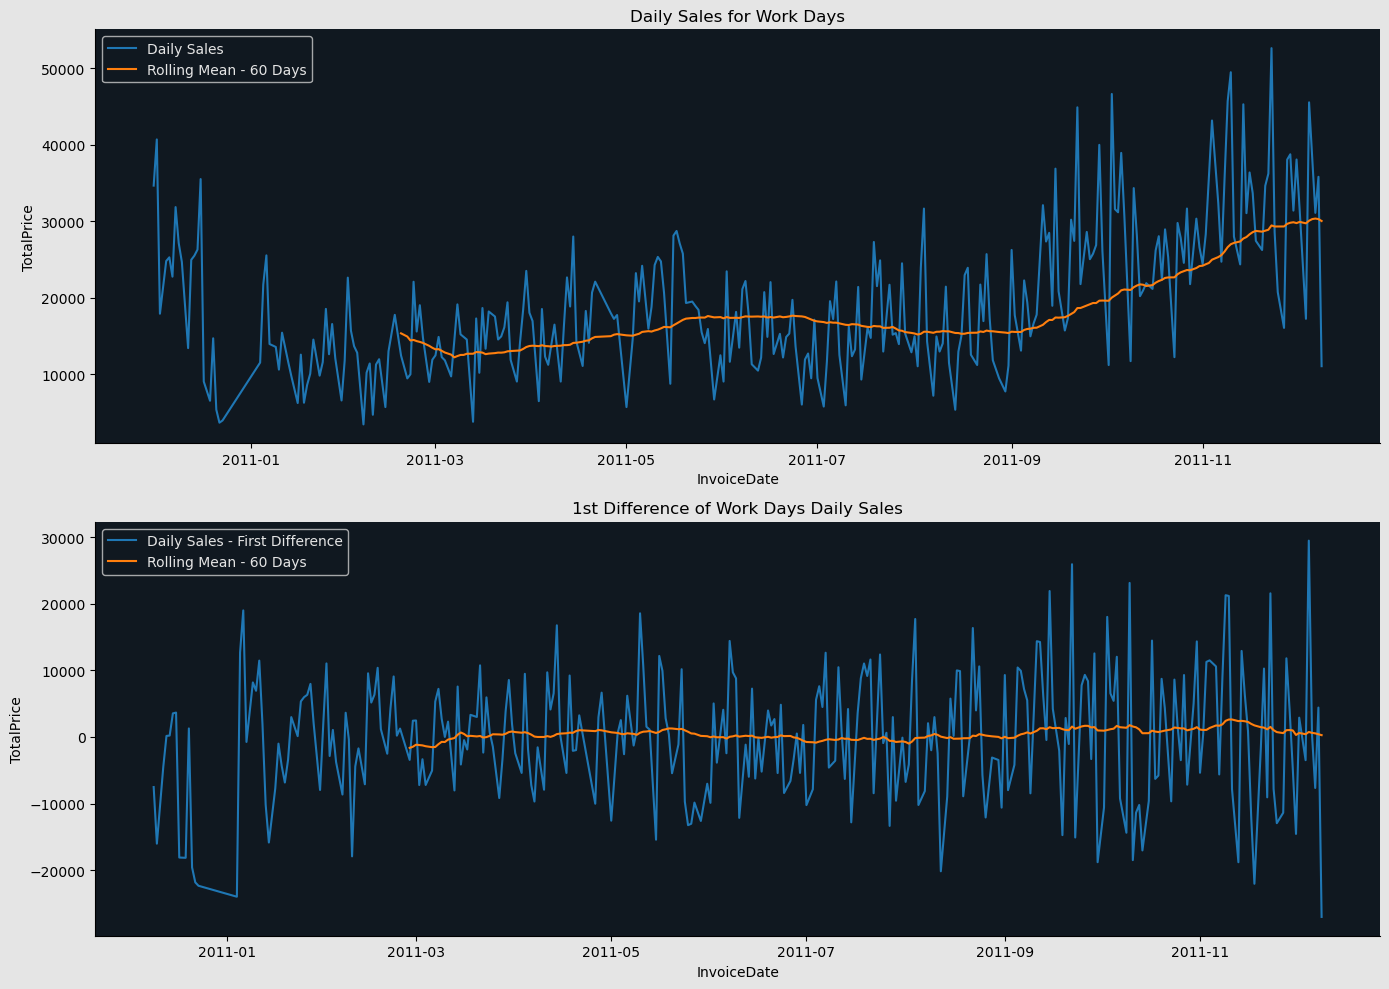

In [24]:
fig, axes = plt.subplots(2, 1, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice,
             ax = axes[0], label = "Daily Sales").set_title("Daily Sales for Work Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(),
             ax = axes[0], label = "Rolling Mean - 60 Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7),
             ax = axes[1], label = "Daily Sales - First Difference").set_title("1st Difference of Work Days Daily Sales")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7).rolling(60).mean(),
             ax = axes[1], label = "Rolling Mean - 60 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.tight_layout()
plt.show()

we have a constant mean over time. Let's look at ADF test results of 1st differenced series.

In [25]:
print("Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)")
check_adf(daily_sales["TotalPrice"].diff(7).dropna())

print("\nPerforming Augmented Dickey-Fuller test for 1st Difference of Work Days Sales")
check_adf(daily_sales_workdays["TotalPrice"].diff(6).dropna())

Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -7.2112411246750865
p-value: 2.2319745316403305e-10
Number of lags: 13

Critical Values : 

	 1% 	 -3.4490114443793214
	 5% 	 -2.8697627072503757
	 10% 	 -2.5711506161673716

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.

Performing Augmented Dickey-Fuller test for 1st Difference of Work Days Sales
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -6.345126133126613
p-value: 2.694674744994143e-08
Number of lags: 11

Critical Values : 

	 1% 	 -3.453342167806272
	 5% 	 -2.871663828287282
	 10% 	 -2.572164381381345

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.


We make the series stationary. Let's decompose and examine its components.



# 3) Seasonality, Decomposition

In [26]:
decompose = seasonal_decompose(daily_sales["TotalPrice"], period = 7)

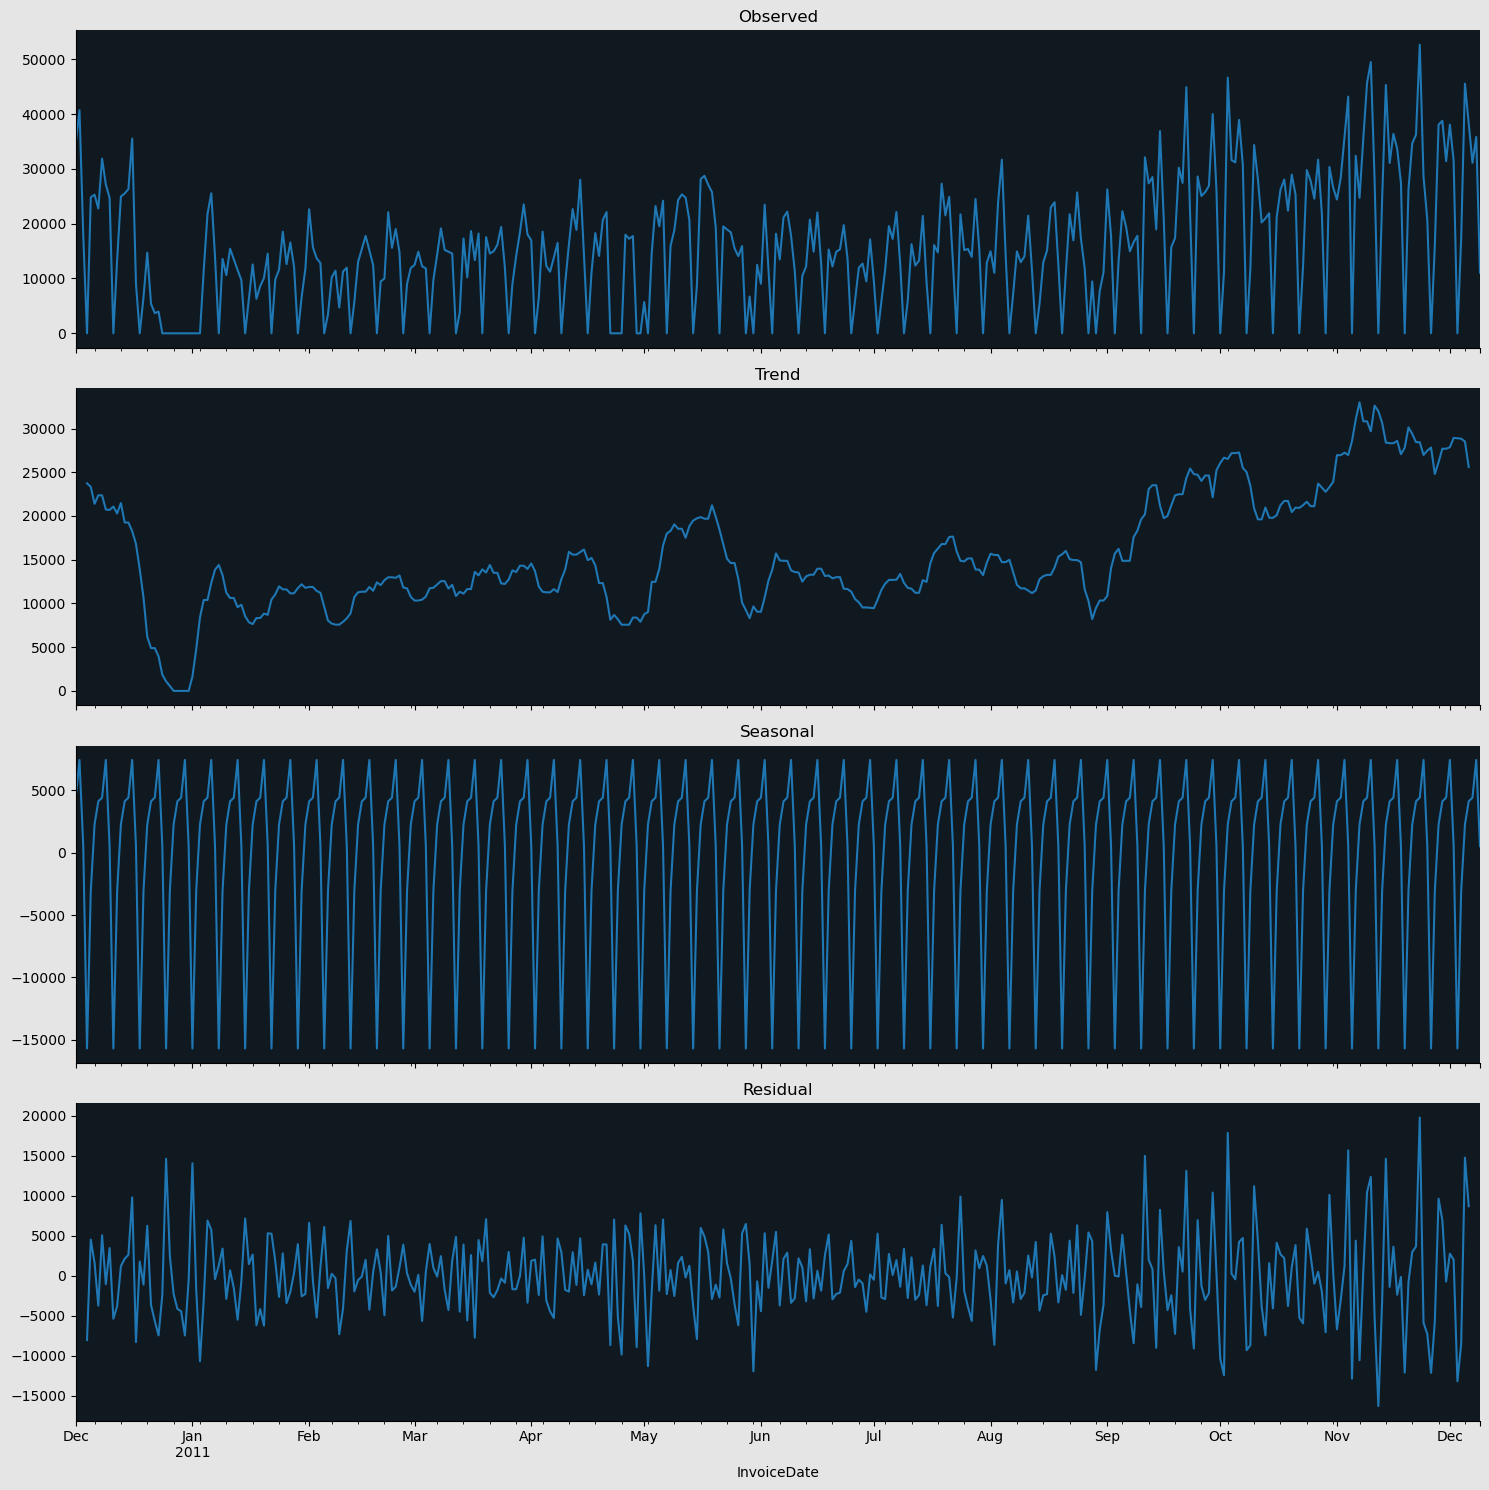

In [28]:
fig, axes = plt.subplots(4, 1, sharex = True, figsize = (15, 15), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

decompose.observed.plot(ax = axes[0]).set_title("Observed")
decompose.trend.plot(ax = axes[1]).set_title("Trend")
decompose.seasonal.plot(ax = axes[2]).set_title("Seasonal")
decompose.resid.plot(ax = axes[3]).set_title("Residual")

sns.despine()
plt.tight_layout()
plt.show()

We can saw trend, seasonal component and residual. We know we have weekly seasonality.

We need normal distributed residual. Let's look at it.

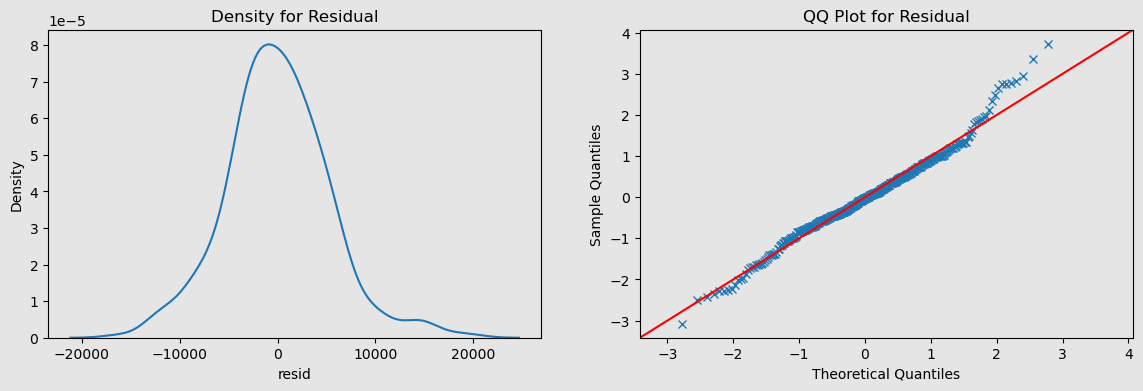

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")

sns.kdeplot(decompose.resid, ax = axes[0]).set_title("Density for Residual")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sm.qqplot(decompose.resid.dropna(), ax = axes[1], marker = "x", line = "45", fit = True)
    axes[1].set_title("QQ Plot for Residual")

plt.show()

As we can see kde plot and QQ plot, residual has normal distribution.

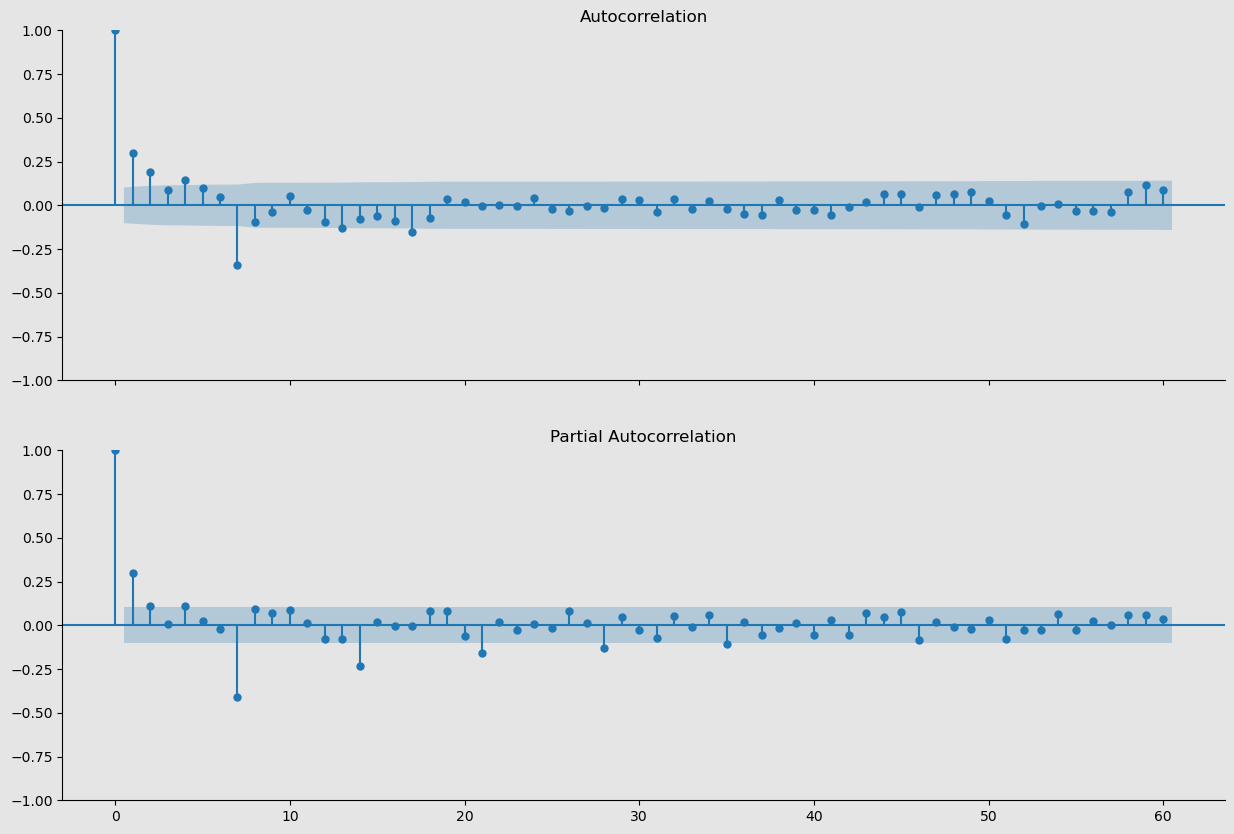

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, sharex = True, figsize = (15, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")

plot_acf(daily_sales["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[0])
plot_pacf(daily_sales["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[1])

sns.despine()
plt.show()



# 4) Modelling

 use daily sales data for model training. We have 0 values on saturdays, it is fixed. We can get rid of these records with subsetting the data, just like stock prices.

For training set,  first 85% records of all days is used, and remaining part is validation set.

 We have one year data and after then major peak, we don't have a lot observations to predicting the behaivor of data.


In [32]:
daily_data = daily_sales[["TotalPrice"]].dropna().reset_index()

daily_data.columns = ["ds", "y"]

train_size = int(0.85 * len(daily_data))

training_data = daily_data.iloc[:train_size]
test_data = pd.DataFrame(daily_data.iloc[train_size:])

print(f"Training Days:\t\t{len(training_data)} \nValidation Days:\t {len(test_data)}")

Training Days:		317 
Validation Days:	 57


For this problem our metrics are R2, mean squared error and correlation. 

In [31]:
def scores(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Correlation: {np.corrcoef(y_true, y_pred)[0][1]}")



## 4.1) Simple Model

In [36]:
from prophet import Prophet

model = Prophet()

model.fit(training_data)

test_pred = model.predict(test_data)
train_pred = model.predict(training_data)

21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:13 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
print("For Training set: \n")
scores(training_data.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(test_data.y, test_pred.yhat)

For Training set: 

R2: 0.5363842272076815
MSE: 42909056.78291415
Correlation: 0.7325443052610539

For Validation set: 

R2: 0.4846090968599477
MSE: 93016518.01181984
Correlation: 0.8403400201548727


First model is simple prophet model with default parameters. We don't have good results, we have 53% R2 for training and 48% R2 for validation set.

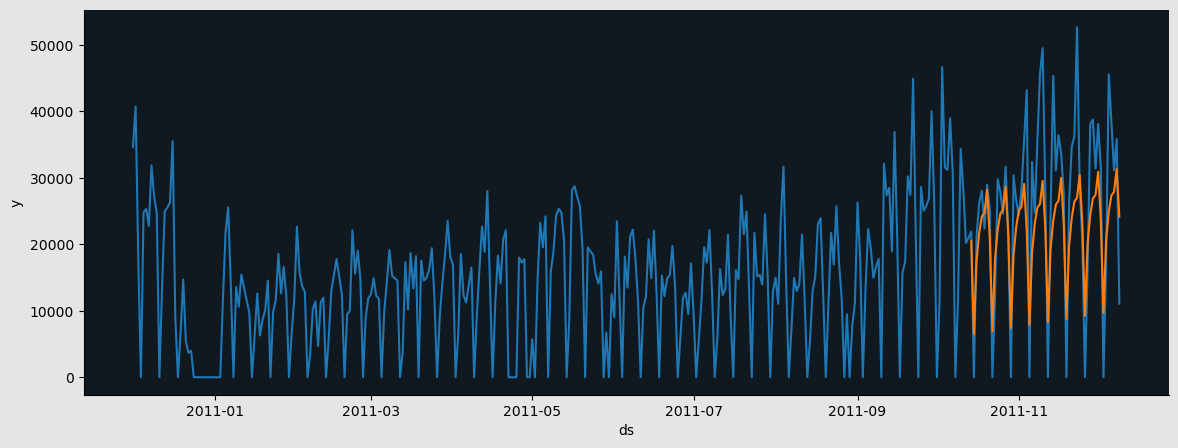

In [38]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax)
sns.lineplot(x = test_pred.ds, y = test_pred.yhat, ax = ax)

sns.despine()
plt.show()

the model does not capture huge peaks.It only moves with seasonality.

Let's add some parameters.



## 4.2) Prophet's parameters

We can add holidays to prophet model with below format.

I just add "Black Friday" as a holiday for three years.

In [41]:
black_friday = pd.DataFrame(
    {
        "holiday": "black friday",
        "ds": pd.to_datetime(["2011-11-24", "2012-11-23", "2013-11-22"]),
        "lower_window": 0,
        "upper_window": 1
    }
)

In saturdays, we don't have any sale record. I will simply add "is_saturday" column as an extra regressor.

In [42]:
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return date.day_name() == "Saturday"

daily_data["is_saturday"] = daily_data["ds"].apply(is_saturday)

training_data = daily_data.iloc[:train_size]
test_data = pd.DataFrame(daily_data.iloc[train_size:])

Prophet gives lots of options in model building step.

holidays: You can use this for adding special days to model.

seasonality: If the data has seasonality, you can set daily_seasonality, weekly_seasonality, and yearly_seasonality parameters to True.

_prior_scale: This parameter controls the flexibility of components' affects.

In this model, I just set them with simple numbers. You can turn them with [0.01-10] range.

Also you can use add_country_holidays(country) method for adding all holidays for a country.

In [44]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True,
    weekly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(training_data)

test_pred = model.predict(test_data)
train_pred = model.predict(training_data)

21:24:21 - cmdstanpy - INFO - Chain [1] start processing
21:24:21 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
print("For Training set: \n")
scores(training_data.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(test_data.y, test_pred.yhat)

For Training set: 

R2: 0.6975700268018992
MSE: 27990818.376720086
Correlation: 0.8353167199134925

For Validation set: 

R2: 0.4713747465836443
MSE: 95405021.90925086
Correlation: 0.8133429451019338


We get 47 % R2 for Test set. Let's plot that results.

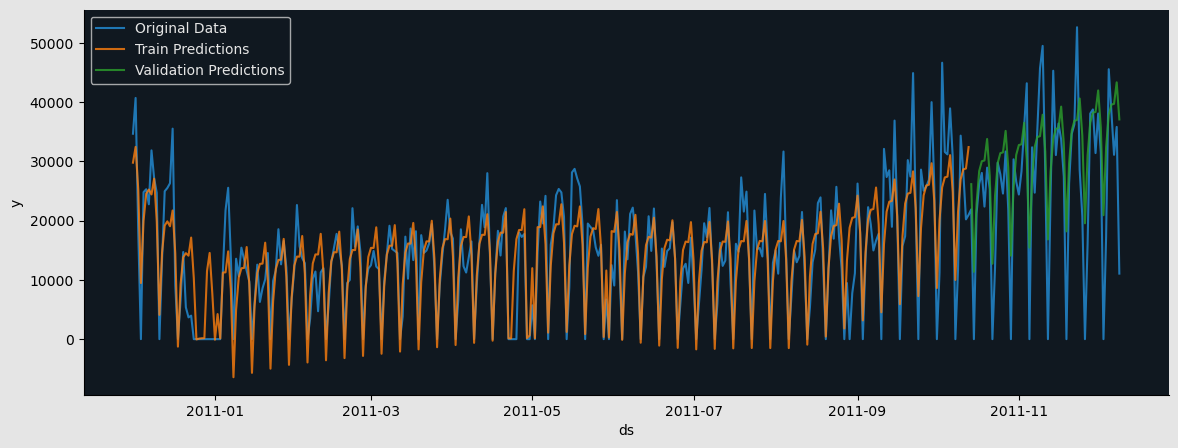

In [47]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = test_pred.ds, y = test_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

 we get negative valued forecasts.
To get rid of this, I will manually set them zero.

In [49]:
train_pred["yhat"] = np.where((train_pred.is_saturday == 0), train_pred.yhat, 0)
test_pred["yhat"] = np.where((test_pred.is_saturday == 0), test_pred.yhat, 0)

print("For Training set: \n")
scores(training_data.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(test_data.y, test_pred.yhat)

For Training set: 

R2: 0.7182861103541638
MSE: 26073481.52661704
Correlation: 0.8484320879387891

For Validation set: 

R2: 0.681466442015255
MSE: 57488175.00103555
Correlation: 0.848647200147765


68% R2 for test set, good increasing.

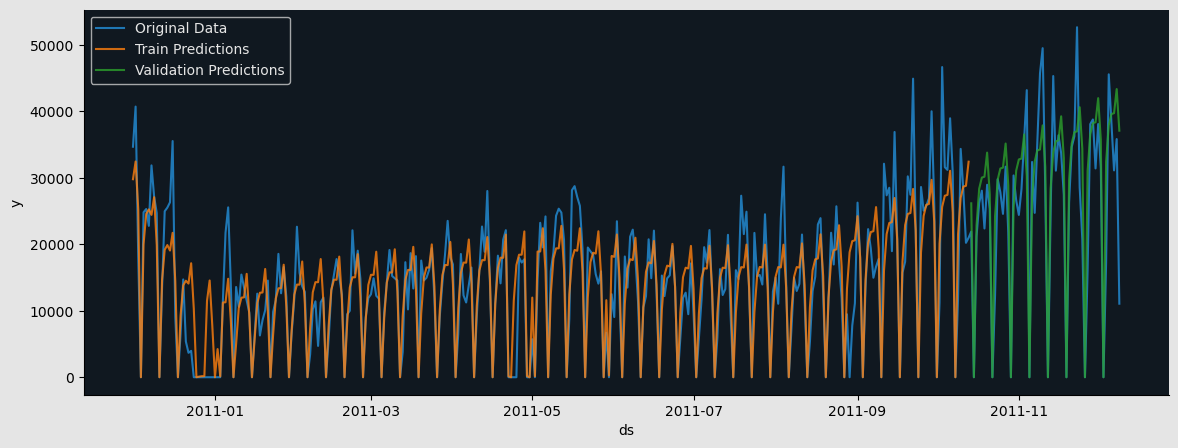

In [50]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = test_pred.ds, y = test_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

Our model can not capture sudden peaks well. Actually, we have to investigate the reasons underlying this peaks. Is it yearly seasonal, or not? We can not detect it since we have only one year data.

<a id="section-five-four-three"></a>

## 4.3) Forecasting Future

Now, I will build a new model for forecasting next year. I just add yearly seasonality to last model that we used.

In [51]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True,
    weekly_seasonality = True,
    yearly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(daily_data)

21:33:09 - cmdstanpy - INFO - Chain [1] start processing
21:33:09 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
future = model.make_future_dataframe(periods = 365)

future["is_saturday"] = future["ds"].apply(is_saturday)
future.tail()

,ds,is_saturday
734,2012-12-04,False
735,2012-12-05,False
736,2012-12-06,False
737,2012-12-07,False
738,2012-12-08,True


In [53]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
734,2012-12-04,33088.647257,25732.500200,40719.764715
735,2012-12-05,32654.056645,25538.720283,39746.993912
736,2012-12-06,35184.814473,27705.676703,42675.435495
737,2012-12-07,27396.182169,20454.578184,35270.924937
738,2012-12-08,9535.767118,2663.278052,16645.352213


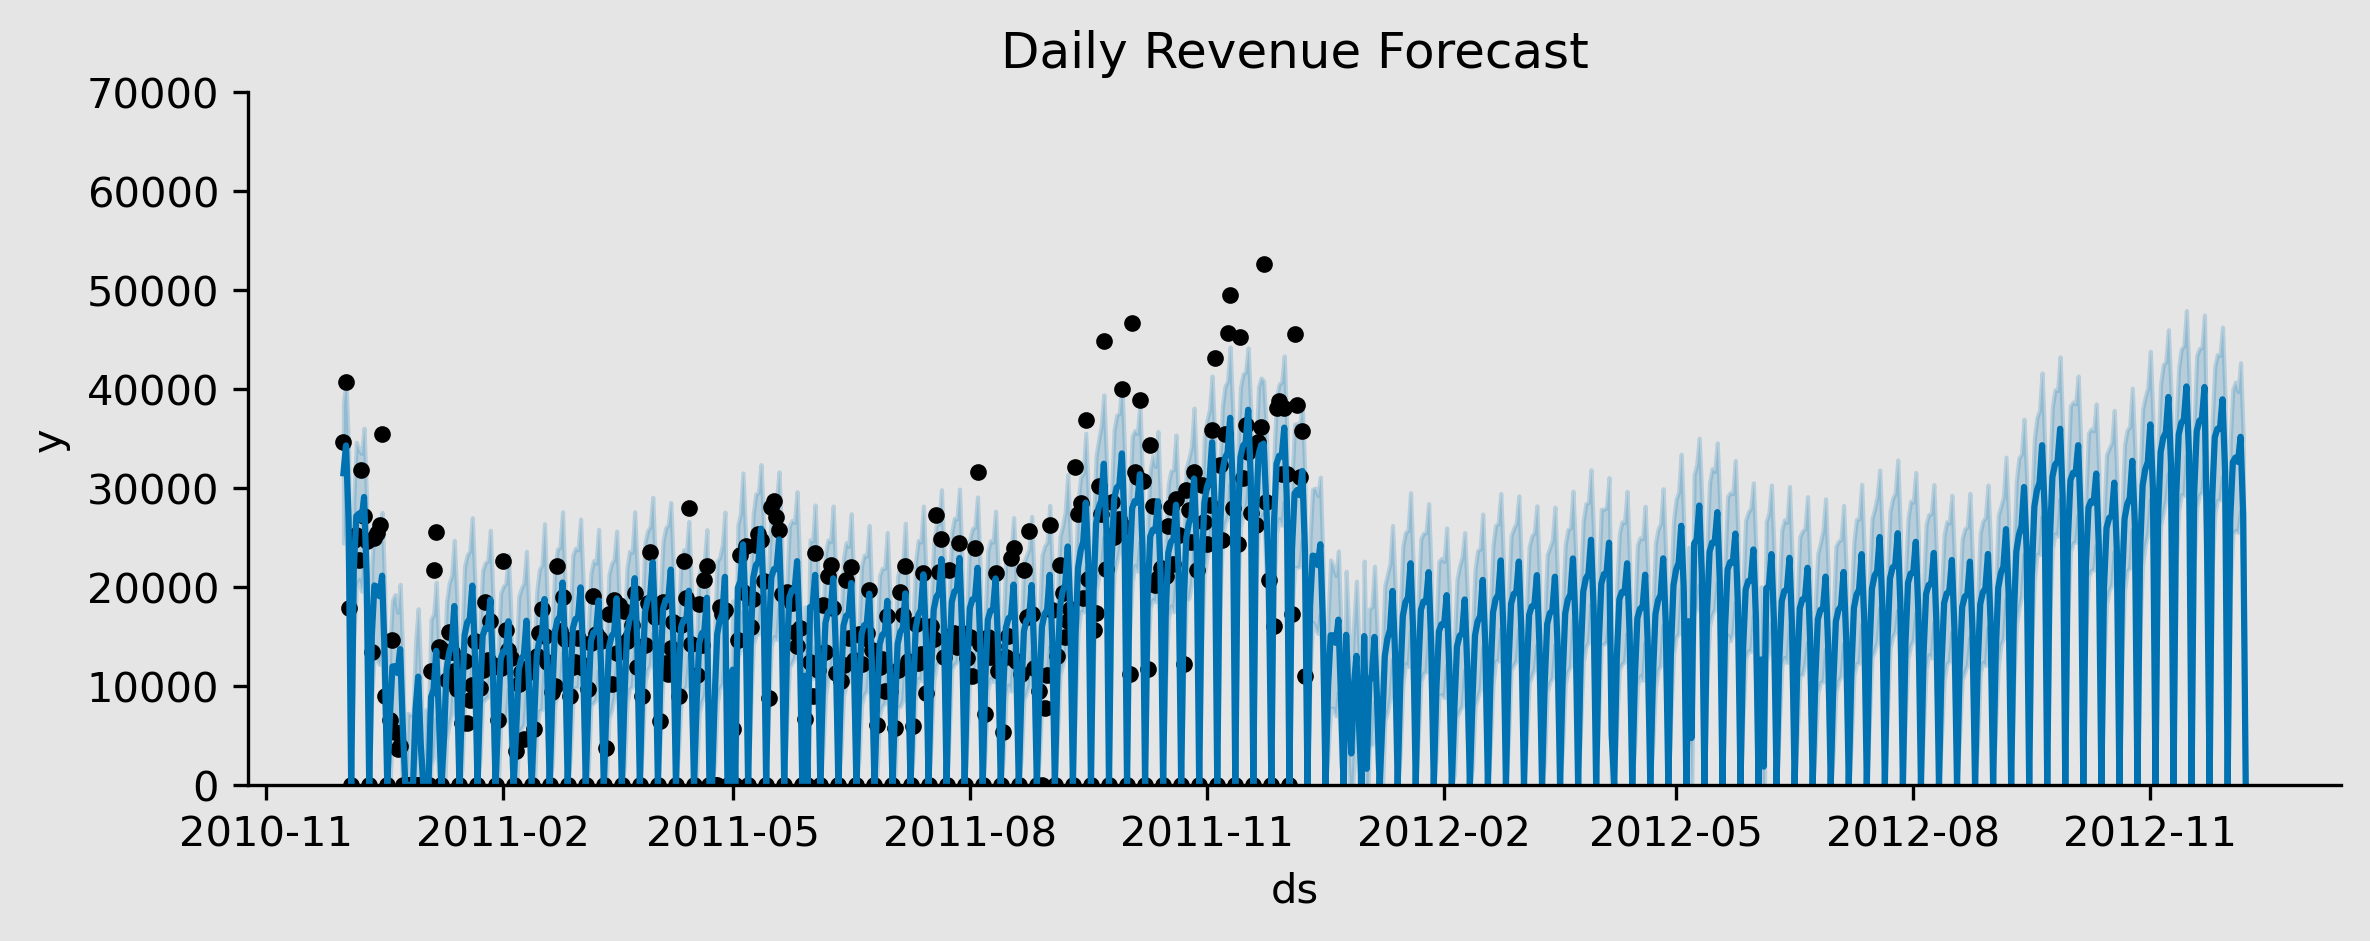

In [54]:
forecast["yhat"] = np.where((forecast.is_saturday == 0), forecast.yhat, 0)
forecast["yhat_lower"] = np.where((forecast.is_saturday == 0), forecast.yhat_lower, 0)
forecast["yhat_upper"] = np.where((forecast.is_saturday == 0), forecast.yhat_upper, 0)

fig, ax = plt.subplots(figsize = (9, 3), facecolor = "#e5e5e5", dpi = 300)

model.plot(forecast, ax = ax)

ax.set_title("Daily Revenue Forecast")
ax.grid(False)
ax.set_facecolor("#e5e5e5")
ax.set_ylim(0, 70000)

sns.despine()
plt.show()

Here is the results of this year's predictions and next year's forecast. Black dots represent actual revenue, and blue lines represent forecasts.

In the last months of the year, our predictions on the border of upper confidence interval, or sometimes outside of it.

If we look at next year's forecast, we can see minor peaks in the middle of the year, and also we have positive trend late of the year.

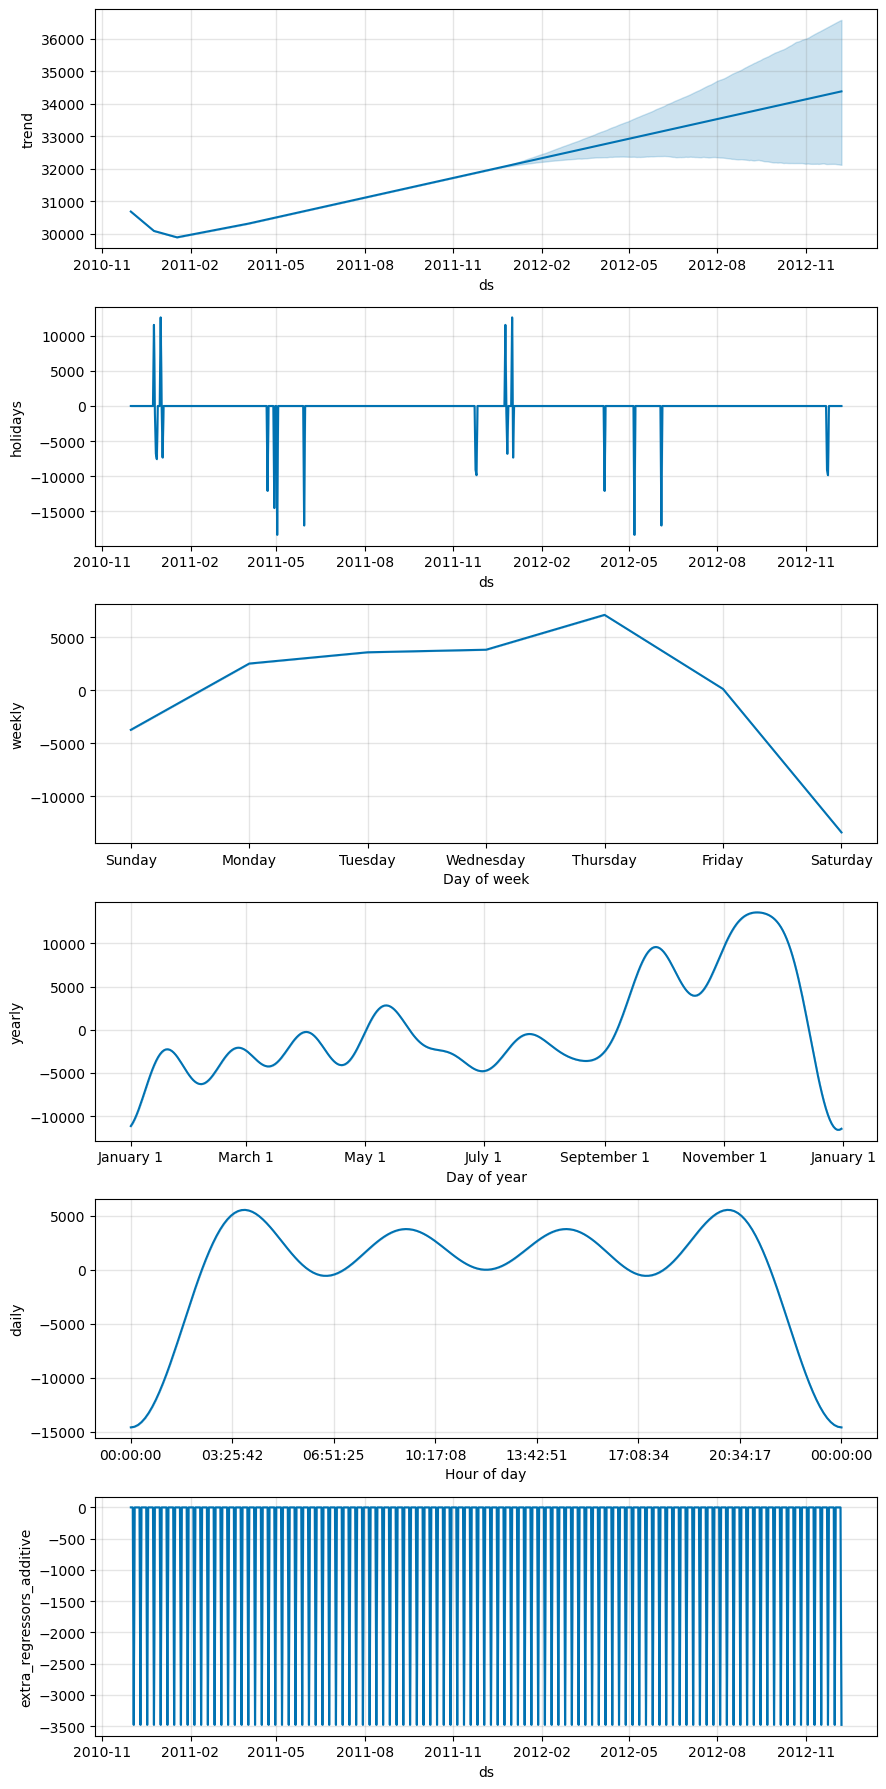

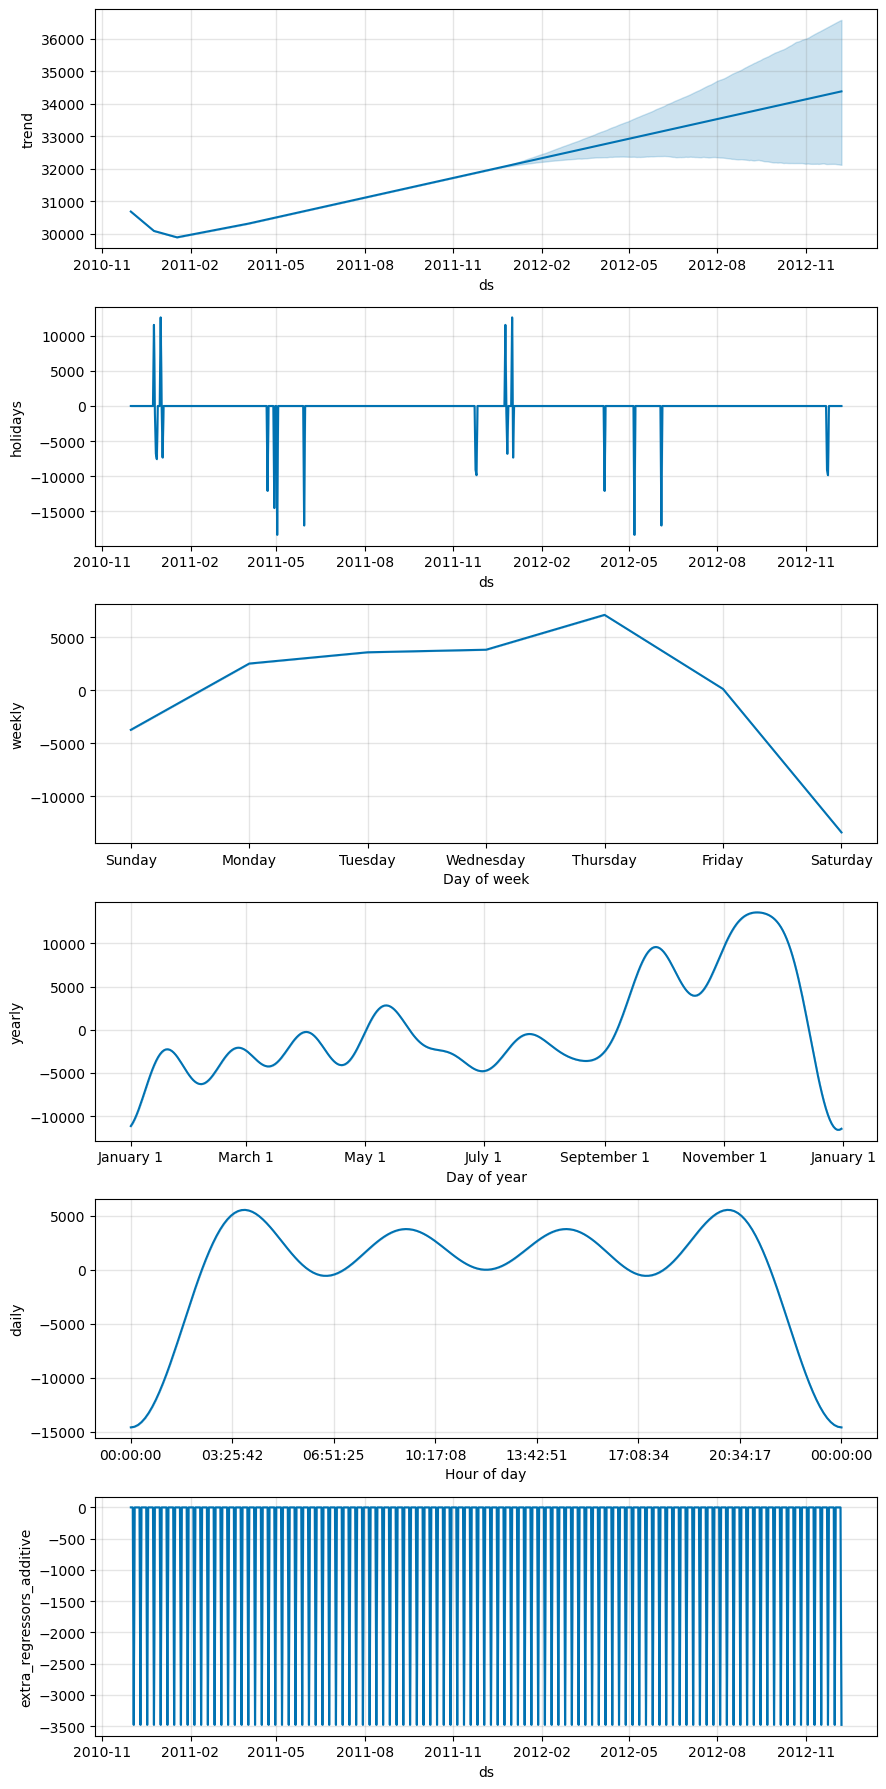

In [58]:

model.plot_components(forecast)


From the above plots its clear that the predicted model have performed well with weekly and yearly trends but seasonal peaks are not yet identified though significantly improved. 
External Factors also affect general trend in the yearly data.
Additional data is required for more in depth analysis

